<a href="https://colab.research.google.com/github/DiploDatos/AprendizajePorRefuerzos/blob/master/lab_2_stable_baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

Créditos:

* Documentación y repo de Stable-baselines https://stable-baselines3.readthedocs.io.
    * Tutorial sobre SB3: https://github.com/araffin/rl-tutorial-jnrr19.
* Documentación y repo de Gymnasium https://github.com/Farama-Foundation/Gymnasium.

Stable-baselines3: framework de deep RL que provee interfaces para ejecutar y adaptar algoritmos de RL "al estilo scikit-learn". Permite utilizar agentes abstrayéndonos de los detalles de bajo nivel de abstracción referentes a la implementación del algoritmo$^1$

Además, ofrece herramientas muy útiles como

* Monitores que permiten ver el rendimiento del agente según se desempeña en el entorno, sin tener que esperar a que finalice de entrenar.
* Callbacks que permiten accionar eventos cuando se cumplen algunas condiciones en el entrenamiento de nuestro agente (por ejemplo, detenerlo si la recompensa recibida es menor a cierto umbral tras un cierto período de tiempo).


Documentación https://stable-baselines3.readthedocs.io

Es un fork activamente mantenido de [OpenAI baselines](https://github.com/openai/baselines)

La versión 3 cambia el framework subyacente de Tensorflow a Pytorch y está activamente en desarrollo; no obstante la versión 2 es completamente funcional

$^1$ no obstante, al igual que sucede generalmente con librerías de ML:

* Siempre es bueno tener en mente las características, ventajas y desventajas del algoritmo utilizado, pues de eso depende mucho la convergencia de nuestra solución, especialmente cuando se emplean entornos adaptados para nuestras necesidades.

* Esta librería, al igual que demás frameworks generales de RL, están muy probadas en entornos estándares de RL como Atari o PyBullet. No obstante, es posible que nuestro entorno o nuestras necesidades difieran significativamente, lo que hace que en algunos casos haya que meter mano directo en el código de los algoritmos/librería.

# Interfaz básica stable-baselines

### Instalación de Stable-baselines


In [1]:
#@title Instalación (no modificar)

# Estamos en Colab?

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip install stable-baselines3[extra]

Desde Windows, además, instalar:
* Microsoft Visual C++ desde https://visualstudio.microsoft.com/visual-cpp-build-tools/
* PyType, mediante `conda install -c conda-forge pytype`

### Instalación de RLBaselinesZoo (Opcional!)

Desde Google Colab

In [2]:
#@title Instalación de RLBaselinesZoo (no modificar)

# Instalamos esta lib opcional?
install_rlzoo = False

if IN_COLAB and install_rlzoo:
    !pip install rl_zoo3

Desde Linux, ejecutando

    git clone --recursive --depth 1 https://github.com/DLR-RM/rl-baselines3-zoo
    cd rl-baselines3-zoo/
    conda install swig
    pip install -r requirements.txt

## Ejecución de un algoritmo de RL

### Importaciones/inicializaciones

In [3]:
import os
from subprocess import Popen, PIPE
from typing import Tuple

import numpy as np

import gymnasium as gym
from gymnasium import spaces

from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold

os.makedirs('logs', exist_ok=True)

cwd = os.getcwd()

%matplotlib inline
%load_ext tensorboard

### Ejemplo básico

In [4]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

# MlpPolicy es una política "estándar" que aprende con perceptron multicapa
# (es decir sin capas convolucionales o demás variantes),
# 2 capas ocultas con 64 neuronas cada una
model = DQN("MlpPolicy", env)
model.learn(total_timesteps=10000)

### Renderización

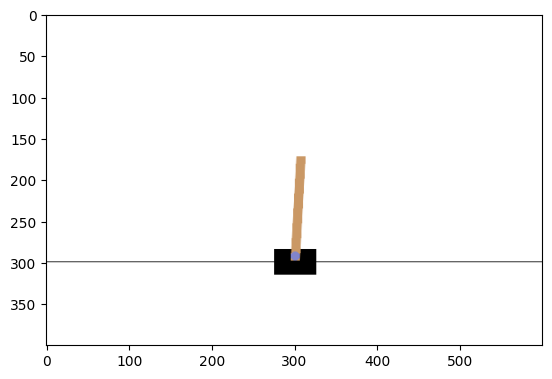

In [5]:
import matplotlib.pyplot as plt

from IPython import display
%matplotlib inline

if not IN_COLAB:
    obs, info = env.reset(seed=42)
    for i in range(3):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)

        plt.imshow(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)

        terminated = terminated or truncated
        if terminated:
            obs, info = env.reset()

    env.close()

### Logging

#### Ver rendimiento del agente en tensorboard

In [6]:
model = DQN("MlpPolicy", gym.make("CartPole-v1"), tensorboard_log="tensorboard/")
model.learn(total_timesteps=100000)

Para verlo en tensorboard, correr

`tensorboard --logdir=tensorboard/`

In [ ]:
%tensorboard --logdir=tensorboard

### Monitor

Vamos a crear un monitor para loguear nuestro agente en la carpeta logs. Nuestro monitor guardará datos de recompensa (r), duración (l) y tiempo total (t)

In [7]:
env = gym.make("CartPole-v1")
env = Monitor(env, "logs/")  # reemplazamos env por su monitor

model = DQN(
    "MlpPolicy",
    env,
)
model.learn(total_timesteps=10000)

### Callbacks

In [8]:
env = gym.make("CartPole-v1")

callbacks = []  # lista de callbacks a usar, pueden ser varios

# callback para detener entrenamiento al alcanzar recompensa de 9.8
# (es una recompensa muy baja, pero la establecemos a fines demostrativos)
stop_training_callback = StopTrainingOnRewardThreshold(reward_threshold=9.8)

# al crear EvalCallback, se asocia el mismo con stop_training_callback
callbacks.append(
    EvalCallback(
        Monitor(env, "logs/"),
        eval_freq=1000,
        callback_on_new_best=stop_training_callback,
    )
)

# la semilla aleatoria hace que las ejecuciones sean determinísticas
model = DQN("MlpPolicy", env, seed=42)
model.learn(total_timesteps=10000, callback=callbacks)

Eval num_timesteps=1000, episode_reward=9.40 +/- 0.80
Episode length: 9.40 +/- 0.80
New best mean reward!
Eval num_timesteps=2000, episode_reward=9.80 +/- 0.75
Episode length: 9.80 +/- 0.75
New best mean reward!


### Ejecutar agente RL en múltiples ambientes

Esta librería provee una interfaz para ejecutar agentes en varias instancias de un mismo entorno a la vez (*vectorized environments*), de modo tal que se habilite la ejecución paralela y de otras funcionalidades útiles.

Para ello, varios de sus algoritmos implementan cambios que consideren la posibilidad de que haya múltiples entornos subyacentes, por ejemplo `step(accion)` cambia a `step(lista_acciones)`, aplicando acciones a todos los entornos, recibiendo ahora múltiples observaciones y recompensas.

Otro cambio: se aplica `reset()` automáticamente a cada entorno que llega a un estado final.

SB brinda dos formas de utilizar entornos vectorizados:

* **DummyVecEnv**, el cuál consiste en un *wrapper* de varios entornos, los cuáles funcionarán en un sólo hilo. Este wrapper es útil como entrada de algoritmos que requieren los entornos de esta forma, y habilita los procesamientos y operaciones comunes de los entornos vectorizados.
* **SubprocVecEnv**, el cuál paraleliza multiples entornos pero en procesos de ejecucíon separados. Cada proceso tiene su propia memoria y puede adquirir derechos sobre las CPUs de la computadora donde se ejecuta. Se utiliza cuando el entorno del agente es computacionalemente complejo. Atención! **Puede comer mucha RAM**.

Vemos un ejemplo:

In [9]:
# ejemplo de ambiente dummy, donde creamos 4 instancias del mismo
venv = DummyVecEnv([lambda: gym.make("CartPole-v1")] * 4)

model = PPO(
    "MlpPolicy",
    venv,
)
model.learn(total_timesteps=10000)

### Ejecutar agente con políticas personalizadas

In [10]:
# Creamos una clase con una red neuronal de 128x128 neuronas

model = PPO(
    "MlpPolicy",
    policy_kwargs=dict(net_arch=[128, 128]),
    env="CartPole-v1",
    verbose=1
)
model.learn(total_timesteps=10000)

Using cpu device
Creating environment from the given name 'CartPole-v1'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.4     |
|    ep_rew_mean     | 20.4     |
| time/              |          |
|    fps             | 6647     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 26.8        |
|    ep_rew_mean          | 26.8        |
| time/                   |             |
|    fps                  | 4241        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009231733 |
|    clip_fraction        | 0.104       |
|    cl

[Buen post](https://medium.com/aureliantactics/understanding-ppo-plots-in-tensorboard-cbc3199b9ba2) en donde se explica qué significan varias de estas métricas. Para verlas en detalle podemos consultar directamente el [código fuente](https://github.com/DLR-RM/stable-baselines3/blob/master/stable_baselines3/ppo/ppo.py), que está bien documentado y no es muy difícil de seguir.

### Utilizar un entorno personalizado

Antes que nada, además de la interfaz que ya vimos de Gym, hay otras nociones que tenemos que tener en cuenta en este contexto:

* Los entornos definen un espacio de estados y de acciones, a partir de los cuáles los modelos asumen y respetan la "forma" de observaciones y acciones. Por ejemplo, algunos algoritmos están diseñados para espacios de acciones discretos (DQN), continuos (DDPG) o bien poseen implementaciones particulares pueden usarse en ambos (PPO, en el repo de SB3). En cuanto a los espacios, algunos algoritmos asumen explícitamente un espacio discreto (y pequeño), como Q-Learning, mientras que otros como PPO asumen cualquier tipo de espacio.
* Los dos tipos más comunes de estados o acciones son los espacios discretos `gym.spaces.Discrete` y los continuos `gym.spaces.Box`.
* Los espacios discretos definen un conjunto de $n$ estados/acciones $\{ 0, 1, \dots, n-1 \}$, mientras que los espacios continuos definen un espacio $\mathbb{R}^d$, de una de las siguientes 4 formas: $[a, b], (-\infty, b], [a, \infty), (-\infty, \infty)$, en donde $a,b$ son las cotas superior e inferior (de existir).
* Ejemplos: un espacio de acciones `Discrete(4)` tiene 4 acciones: $\{0,1,2,3\}$; un espacio de estados `Discrete(16)` tiene 16 estados. Un espacio de estados ALTURA, ANCHO, N_CANALES que represente una imagen RGB acotada en $[a=0, b=255]$ se puede crear como

`observation_space = spaces.Box(low=0, high=255, shape=(HEIGHT, WIDTH, N_CHANNELS), dtype=np.uint8)`

Para usar un entorno compatible por esta librería, el mismo tiene que heredar de *gym.Env*. Vemos un ejemplo (crédito: Antonin Raffin https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb)

In [11]:
class GoLeftEnv(gym.Env):
    """
    Ambiente personalizado que sigue la interfaz de gym.
    Es un entorno simple en el cuál el agente debe aprender a ir siempre
    hacia la izquierda.
    """

    # Dado que podemos estar en colab, no podemos implementar la salida
    # por interfaz gráfica ('human' render mode)
    metadata = {"render.modes": ["console"]}
    # Definimos las constantes
    LEFT = 0
    RIGHT = 1

    def __init__(self, grid_size=10):
        super(GoLeftEnv, self).__init__()

        # Tamaño de la grilla de 1D
        self.grid_size = grid_size
        # Inicializamos en agente a la derecha de la grilla
        self.agent_pos = grid_size - 1

        # Definimos el espacio de acción y observaciones
        # Los mismos deben ser objetos gym.spaces
        # En este ejemplo usamos dos acciones discretas: izquierda y derecha
        n_actions = 2
        self.action_space = spaces.Discrete(n_actions)
        # La observación será la coordenada donde se encuentra el agente
        # puede ser descrita tanto por los espacios Discrete como Box
        self.observation_space = spaces.Box(
            low=0, high=self.grid_size, shape=(1,), dtype=np.float32
        )

    def reset(self, seed=None) -> Tuple[np.array, dict]:
        """
        Reinicia el ambiente y devuelve la observación inicial

        Importante: la observación devuelta debe ser un array de numpy
        :return: (np.array, dict)
        """

        # Se inicializa el agente a la derecha de la grilla
        self.agent_pos = self.grid_size - 1

        # convertimos con astype a float32 (numpy) para hacer más general
        # el agente (en caso de que querramos usar acciones continuas)
        return (np.array([self.agent_pos]).astype(np.float32), {})

    def step(self, action):
        if action == self.LEFT:
            self.agent_pos -= 1
        elif action == self.RIGHT:
            self.agent_pos += 1
        else:
            raise ValueError(
                f"Se recibió una acción inválida={action} que no es parte del\
                    espacio de acciones"
            )

        # Evitamos que el agente se salga de los límites de la grilla
        self.agent_pos = np.clip(self.agent_pos, 0, self.grid_size)

        # Llegó el agente a su estado objetivo (izquierda) de la grilla?
        terminated = bool(self.agent_pos == 0)
        truncated = False  # no limitamos la duración de los episodios

        # Asignamos recompensa sólo cuando el agente llega a su objetivo
        # (recompensa = 0 en todos los demás estados)
        reward = 1 if self.agent_pos == 0 else 0

        # gym también nos permite devolver información adicional, ej. en Atari:
        # las vidas restantes del agente (no usaremos esto por ahora)
        info = {}

        return (
            np.array([self.agent_pos]).astype(np.float32),
            reward,
            terminated,
            truncated,
            info,
        )

    def render(self, mode="console"):
        if mode != "console":
            raise NotImplementedError()
        # en nuestra interfaz de consola, representamos el agente como una
        # cruz, y el resto como un punto
        print("." * self.agent_pos, end="")
        print("x", end="")
        print("." * (self.grid_size - self.agent_pos))

    def close(self):
        pass

In [12]:
# validamos que el ambiente cumpla con la interfaz de gym
from stable_baselines3.common.env_checker import check_env

env = GoLeftEnv()
# Si el entorno no cumple con la interfaz, se lanzará una excepción
check_env(env, warn=True)

In [13]:
env = GoLeftEnv(grid_size=10)

model = PPO("MlpPolicy", env, verbose=1).learn(20000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 101      |
|    ep_rew_mean     | 1        |
| time/              |          |
|    fps             | 6571     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 55.6        |
|    ep_rew_mean          | 1           |
| time/                   |             |
|    fps                  | 4702        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.019783046 |
|    clip_fraction        | 0.378       |
|    clip_range           | 0.2         |
|    entropy_loss   

Vemos agente entrenado

In [14]:
obs, _ = env.reset()
env.render()

print(env.observation_space)
print(env.action_space)
print(env.action_space.sample())

GO_LEFT = 0
# Agent óptimo: siempre va hacia la izquierda!
n_steps = 20
for step in range(n_steps):
    print(f"Step {step + 1}")
    obs, reward, terminated, truncated, info = env.step(GO_LEFT)
    done = terminated or truncated
    print("obs=", obs, "reward=", reward, "done=", done)
    env.render()
    if done:
        print("Objetivo cumplido!", f"reward={reward}")
        break

.........x.
Box(0.0, 10.0, (1,), float32)
Discrete(2)
1
Step 1
obs= [8.] reward= 0 done= False
........x..
Step 2
obs= [7.] reward= 0 done= False
.......x...
Step 3
obs= [6.] reward= 0 done= False
......x....
Step 4
obs= [5.] reward= 0 done= False
.....x.....
Step 5
obs= [4.] reward= 0 done= False
....x......
Step 6
obs= [3.] reward= 0 done= False
...x.......
Step 7
obs= [2.] reward= 0 done= False
..x........
Step 8
obs= [1.] reward= 0 done= False
.x.........
Step 9
obs= [0.] reward= 1 done= True
x..........
Objetivo cumplido! reward=1


## Normalización de features y recompensas

Stable-Baselines3 tiene predefinidos un conjunto de **wrappers** genericos que pueden utilizarse para preprocesar las observaciones que llegan al agente RL, desacoplando del mismo el prepocesamiento.

Entre las funcionalidades disponibles tenemos:
* **VecFrameStack**: Se utiliza cuando la observación que percibe el agente es una imagen. Sirve para expandir el espacio de estados apilando N frames de manera conjunta (ver [paper de DQN](https://arxiv.org/abs/1312.5602) para más detalle).
* **VecNormalize**: Se utiliza para normalizar las observaciónes y/o las recompensas que percibe el agente, a $\mu=0$ y $\sigma=1$. También permite cortar valores de observaciones y/o recompensas que excedan un rango establecido.
* **VecCheckNan**: Se utiliza para trackear los estados del entorno que generan que los gradientes de la RNN se hagan NaN.
* **VecVideoRecorder**: Se utiliza para exportar el funcionamiento de la política aprendida por el agente a un video (MP4).

Ademas, se pueden crear **wrappers** personalizados extendiendo la clase **VecEnvWrapper**:

```
class MiWrapper(VecEnvWrapper):
    [...]
```
### Ejemplo (VecNormalize)

In [15]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

env = gym.make("CartPole-v1")
# Multiples entornos vectorizados. Normalizamos tanto observaciones como
# recompensas, y recortamos ambas cuando exceden 10
env = DummyVecEnv([lambda: env])
env = VecNormalize(
    env, norm_obs=True, norm_reward=True, clip_obs=10.0, clip_reward=10.0
)

model = DQN("MlpPolicy", env)
model.learn(total_timesteps=10000)

# RL-baselines3-zoo

Colección de agentes RL y herramientas útiles para ejecutarlos, evaluarlos e incluso hacer videos con ellos. Los agentes de este repo están preparados con la configuración requerida para los distintos tipos de entornos, incluyendo Atari, PyBullet y entornos clásicos, incluyendo configuraciones e híper-parámetros que producen buenas políticas para tales entornos.

Esta librería ofrece un muy buen punto de partida para utilizar agentes / entornos personalizados, ya que ofrece una [interfaz](https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/train.py) fácilmente adaptable a nuestras necesidades.

Si se usan entornos personalizados con rl-baselines3-zoo, debe tenerse en cuenta que se deben definir todos los híper-parámetros de antemano, sea al instanciar el agente, o en la carpeta */rl-baselines3-zoo/hyperparams*; de lo contrario arrojará error por no encontrar qué híper-parámetro usar.

**Importante:** esta librería es enteramente opcional, no es necesaria para realizar los labs.

In [16]:
try:
    import rl_zoo3
    zoo_installed = True
except ImportError as e:
    zoo_installed = False

zoo_installed

True

## Ejecución

Los agentes pueden ser llamados desde la consola mediante comandos como

`python train.py --algo algo_name --env env_id`

Los cuales pueden ser llamados usando

In [17]:
if zoo_installed:
    # lo siguiente es equivalente a ejecutar en la terminal:
    # python -m rl_zoo3.train --algo ppo --env CartPole-v1

    args = ["--algo", "ppo", "--env", "CartPole-v1"]

    p = Popen(
        ["python", "-m", "rl_zoo3.train"] + args, stdin=PIPE, stdout=PIPE, stderr=PIPE
    )
    output, err = p.communicate()
    rc = p.returncode
    os.chdir(cwd)
    assert rc == 0

Ver en acción el agente entrenado (nota: no disponible en Google Colab, requiere ffmpeg)

In [18]:
if not IN_COLAB and zoo_installed:
    # lo siguiente es equivalente a ejecutar en la terminal:
    # python -m rl_zoo3.enjoy --algo ppo --env CartPole-v1 --folder logs/

    args = ["--algo", "ppo", "--env", "CartPole-v1", "--folder", "logs/"]

    p = Popen(
        ["python", "-m", "rl_zoo3.enjoy"] + args, stdin=PIPE, stdout=PIPE, stderr=PIPE
    )
    output, err = p.communicate()
    rc = p.returncode
    os.chdir(cwd)
    assert rc == 0

También es posible grabar un video! Ver https://stable-baselines3.readthedocs.io/en/master/guide/examples.html#record-a-video

Ver curva de aprendizaje obtenida por el agente desde *utils.plot*

In [19]:
# equivalente a ejecutar en la terminal:
# python -m rl_zoo3.plots.plot_train --algo ppo --env CartPole-v1 --exp-folder logs/

args = ["--algo", "ppo", "--env", "CartPole-v1", "--exp-folder", "logs/"]

p = Popen(["python", "-m", "rl_zoo3.plots.plot_train"] + args, stdout=PIPE)
output, err = p.communicate()
rc = p.returncode
os.chdir(cwd)

assert rc == 0

/Users/gonzalo/.pyenv/versions/3.10.11/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py:126: RuntimeWarning: 'rl_zoo3.plots.plot_train' found in sys.modules after import of package 'rl_zoo3.plots', but prior to execution of 'rl_zoo3.plots.plot_train'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


In [20]:
print(output) # TODO decode this output

b'Figure(640x480)\n'


## Híper-parámetros

rl-baselines-zoo provee híper-parámetros que resultan en curvas de aprendizaje que convergen en buena cantidad de entornos. Estos híper-parámetros pueden verse en cada uno de los archivos YAML de cada algoritmo, [acá](https://github.com/DLR-RM/rl-baselines3-zoo/tree/master/hyperparams).

También provee funcionalidad para optimizar los híper-parámetros con la librería [Optuna]( https://github.com/optuna/optuna). En los mismos se incluyen rangos de híper-parámetros que se usaron para optimizar entornos como los de PyBullet, y son fácilmente modificables para adaptarlo a nuestros propios entornos. Para ver cómo se llama a la interfaz de Optuna ver [este código](https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/utils/hyperparams_opt.py).

Nota: **Optuna come muchos recursos!**

# Entrenando otros agentes

### Algunos conjuntos de entornos

CartPole es una excelente línea base (de hecho suele ser la prueba preliminar de todo nuevo algoritmo), porque tiene recompensas constantes pero requiere cierta solidez por parte del algoritmo para hacerlo converger al óptimo.

No obstante, al implementar un algoritmo, es deseable que el mismo pueda desenvolverse de forma consistente en varios grupos de entornos. A continuación va una lista con varios entornos que sirven como prueba:

| Entornos                                                                                                           | Estados            | Acciones            | Dificultad      | Implementado por                                                                                                                                                            |
|--------------------------------------------------------------------------------------------------------------------|--------------------|---------------------|-----------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Clásicos (CartPole, MountainCar, Pendulum, Deep sea (testea exploración), umbrella (testea asignación de crédito)) | Discretos/Continuos          | Continuas/discretas | Baja/Media      | [Gym](https://github.com/openai/gym/wiki/Table-of-environments) y [BSuite](https://github.com/deepmind/bsuite)                                                                                                                          |
| Grilla (desde pequeñas donde hay que salir hasta grandes con muchas habitaciones y subproblemas)                   | Discretos/imágenes | Discretas           | Baja/Media/Alta | [gym-minigrid](https://github.com/maximecb/gym-minigrid)                                                                                                                    |
| Grilla/plataforma/estilo Atari, generados proceduralmente                                                          | Imágenes           | Discretas           | Media/Alta      | [Gym](https://github.com/openai/procgen)                                                                                                                                    |
| Plataforma 2D, como LunarLander o BipedalWalker                                                                    | Continuos          | Continuas/discretas | Media/Alta      | [Gym](https://github.com/openai/gym/wiki/Table-of-environments)                                                                                                                                                                         |
| Primera persona en 3D                                                                                              | Imágenes           | Continuas/discretas | Media/Alta      | [Deepmind](https://github.com/deepmind/lab)                                                                                                                                 |
| Simulación física de pequeños robots                                                                               | Continuos          | Continuas           | Media/Alta      | Gym (con el motor [MuJoCo](https://mujoco.org/) o [PyBullet](https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit#heading=h.wz5to0x8kqmr)) |
| Atari                                                                                                              | Continuos          | Discretas           | Media/Alta      | [Gym](https://github.com/openai/gym/wiki/Table-of-environments) (son todos aquellos entornos que terminan en "*-v4*"                                                                                                                                                                         |


## Resumen de algunos algoritmos

Se resumen ahora varios algoritmos del estado del arte de aprendizaje por refuerzos profundo



| Algoritmo | Tipo       | Espacio de acciones | Resumen rápido                                                                                                                                                | Artículo                         |
|-----------|------------|---------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------|
| DQN       | Off-policy | Discretas           | Extiende Q-Learning a deep learning. En Stable-baselines, DQN incluye todas las mejoras ya incorporadas.                                                      | https://arxiv.org/abs/1312.5602  |
| ACER      | Off-policy | Discretas           | Combina una arquitectura actor-critic con un buffer y repetición de experiencia.                                                                              | https://arxiv.org/abs/1611.01224 |
| A3C       | On-policy  | Ambos               | Múltiples agentes corriendo en múltiples instancias del ambiente, acumulando sus gradientes y actualizándolos tras un cierto tiempo.                          | https://arxiv.org/abs/1602.01783 |
| PPO       | On-policy  | Ambos               | Punta de lanza de policy gradient, incluye mecanismo para que el gradiente actualice de forma acotada, mejorando drásticamente la estabilidad.             | https://arxiv.org/abs/1707.06347 |
| DDPG      | Off-policy | Continuas           | Como en espacios de acciones continuos es muy difícil encontrar $\max_a Q(s,a)$, se aproxima via $Q(s, a(s \mid \theta_a))$, siendo $a$ un actor estocástico. | https://arxiv.org/abs/1509.02971 |
| TD3       | Off-policy | Continuas           | Mejora DDPG utilizando dos funciones $Q$ y retrasando la actualización para reducir la sobreestimación de $Q$.                                                | https://arxiv.org/abs/1802.09477 |
| SAC       | Off-policy | Continuas           | Usa dos funciones $Q$, introduce el bonus por entropía y usa un actor estocástico que muestrea acciones según una política $\pi$.                             | https://arxiv.org/abs/1801.01290 |

## Resumen de algunas herramientas/trucos comúnmente usados

* Experience replay/buffer de experiencia: guarda las experiencias en un buffer para poder usarlas repetidamente durante el entrenamiento.
    * Ventajas: experiencias raras pero muy relevantes (ej: que tienen mucho error de actualización) quedan guardadas en memoria, pudiendo ser usadas repetidamente para aprender sin necesidad de esperar a que se repitan.
    
    En métodos de gradiente de política, en cambio, el aprendizaje queda reflejado en los pesos, lo cuál puede hacer que un agente no se desenvuelva correctamente en entornos de recompensa escasa como MountainCar.
    
    * Desventajas: requiere considerable RAM, son usables solamente en algoritmos off-policy y su muestreo no necesariamente refleja la probabilidad real de tener esas experiencias en el entorno (añadiendo sesgo), por lo que es recomendable usarlo junto con importance sampling.
    
* Importance sampling: aplica un descuento a las actualizaciones a partir de experience replay relacionado a cuán probable era realizar esa transición.
* Entropía: añade un bonus a la función de recompensa para que bonifique políticas $\pi(s \mid a)$ que tengan mayor entropía que otras, motivando la exploración del agente.
* Juntar varias secuencias de imágenes. Usado principalmente en entornos de Atari para poder evaluar la dirección de movimientos.
* Normalización de recompensas/estados. Normaliza las recompensas y observaciones usualmente con una media móvil, de modo tal que las observaciones/recompensas reflejen su relación y varianza con respecto a las demás.
* Clipping (recorte) de recompensas. Se usaba principalmente en entornos de Atari con algoritmos tipo DQN para recortar el impacto que las distintas recompensas tenían, a una constante (ej: 1). Suele usarse como una cota máxima de recompensas/observaciones normalizadas.

# Lab 2

1. Crear tu propio entorno y entrenar agentes RL en el mismo. Analizar la convergencia con distintos algoritmos* (ej: PPO, DQN), resultados con distintas funciones de recompensa e híper-parámetros.

    Algunas ideas:

    * Transformar GoLeftEnv en una grilla 2D, añadir paredes / trampas / agua.
    * Crear un entorno que juegue a algún juego como el ta-te-ti.
    * Crea un entorno totalmente nuevo que sea de tu interés!

2. Entrena agentes en entornos más complejos con stable-baselines/rl-baselines-zoo. Tener en cuenta:

    * Google Colab tiene una limitante en cuanto a cantidad de recursos de CPU/GPU (incluido un "rendimiento decreciente silencioso"), lo cuál reduce la capacidad de entrenar distintos entornos.
    * Si el entorno no está implementado en stable-baselines, debe hacerse un wrapper a mano, lo que puede ser sencillo o puede llevar algo más de trabajo, teniendo que tocar código subyacente de la librería.

\* pueden ser usando los agentes de stable-baselines, de rl-baselines-zoo, o bien utilizando algún otro algoritmo (incluso tabular)

# Punto 1: entorno propio

El entorno va a representar el siguiente juego:
El personaje es una hormiga tratando de llegar hasta su fuente de comida antes de que se haga de noche. En su camino hay:
 * Arañas esperando en su tela a que algo se pegue para comerlo
 * Piedras que no puede mover
 * Paredes que puede cavar pero hacen que tenga que descansar y no puede hacer nada en el turno siguiente

El juego está representado como una grilla 2D como si fuera visto desde arriba con las siguientes referencias:
 * H es la hormiga
 * C es la comida
 * X es una tela de araña, si cae acá tiene una probabilidad del 85% de morir y un 15% de escapar
 * \# es una pared que puede atravesar
 * O es una piedra que no puede mover

Se ve de esta forma:

```
Turnos: 20
############
#H   O   XX#
#    O     #
# X     X  #
#======    #
# X   =  X #
#      C   #
############
```

## Recompensas

Se va a experimentar con 3 funciones de recompensa:

* **Básica**: otorgar una recompensa de 1 cuando se llega al objetivo y 0 en cualquier otro caso
* **Por cantidad de turnos**: otorgar un nivel de recompensa igual a la cantidad de turnos que le quedan por jugar a la hora de ganar. Intenta incentivar la velocidad de conseguir el objetivo
* **Por paso**: devolver distintos valores de recompensa en cada paso para penalizar o reforzar distintas acciones del agente.

## Algoritmos

Se experimentará con los algoritmos *PPO*, *DQN* y *A2c* que deberian funcionar para acciones discretas.

In [21]:
from random import random
from copy import deepcopy

class AntGame(gym.Env):
    """
    Implementa el juego de la hormiga en
    """
    metadata = {"render.modes": ["console"]}

    # Definimos las constantes
    UP = 0
    RIGHT = 1
    DOWN = 2
    LEFT = 3

    def __init__(self, reward_func=None):
        super(AntGame, self).__init__()

        # Guardamos que función de reward se va a usar
        reward_funcs = {
            "reward_one_on_win": self.reward_one_on_win,
            "reward_steps_it_took_to_win": self.reward_steps_it_took_to_win,
            "reward_different_on_each_step": self.reward_different_on_each_step,
        }
        self.reward_func = reward_funcs.get(reward_func, self.reward_one_on_win)

        # Inicializamos el juego
        self.reset()

        # Definimos el espacio de acción y observaciones
        n_actions = 4
        self.action_space = spaces.Discrete(n_actions)

        # La observación será la coordenada donde se encuentra el agente
        # puede ser descrita tanto por los espacios Discrete como Box
        self.observation_space = spaces.Box(
            low=0, high=4,
            shape=(2,),
            dtype=np.int64
        )

    def load_map(self):
        grid_str = """
        ############
        #    O   XX#
        #    O     #
        # X     X  #
        #======    #
        # X   =  X #
        #      C   #
        ############
        """

        grid = []
        for line in grid_str.split("\n")[2:-2]:
            row = list(line.strip()[1:-1])
            grid.append(row)

        return grid

    def get_win_position(self):
        for y, row in enumerate(self.grid):
            for x, char in enumerate(row):
                if char == "C":
                    return y, x

    def reset(self, seed=None) -> Tuple[np.array, dict]:
        """
        Reinicia el ambiente y devuelve la observación inicial
        """
        # Se inicializa el mapa y la posicion del jugador
        self.grid = self.load_map()
        self.player_pos = (0, 0)
        self.skip_turn = False
        self.turns_left = 30
        self.win_position = self.get_win_position()
        self.max_y = len(self.grid) - 1
        self.max_x = len(self.grid[0]) - 1

        # convertimos con astype a float32 (numpy) para hacer más general
        # el agente (en caso de que querramos usar acciones continuas)
        return (np.array(self.player_pos), {})

    def get_next_pos(self, action):
        x = self.player_pos[1]
        y = self.player_pos[0]

        if action == self.UP:
            y = y - 1 if y != 0 else y
        elif action == self.RIGHT:
            x = x + 1 if x != self.max_x else x
        elif action == self.DOWN:
            y = y + 1 if y != self.max_y else y
        elif action == self.LEFT:
            x = x - 1 if x != 0 else x

        return (y, x)

    def step(self, action):
        char_on_next_pos = ""
        previous_pos = self.player_pos
        died = False
        truncated = False

        # Siempre se resta un turno
        self.turns_left = self.turns_left - 1

        if self.skip_turn:
            # Saltea el turno
            self.skip_turn = False
        else:
            # Ejecutar la acción
            next_y, next_x = self.get_next_pos(action)
            char_on_next_pos = self.grid[next_y][next_x]

            if char_on_next_pos == " ":
                # No hay nada, hay que mover el jugador
                self.player_pos = (next_y, next_x)
            elif char_on_next_pos == "O":
                # Tope con una piedra, no hay que mover el jugador
                pass
            elif char_on_next_pos == "X":
                # Tela de araña, sortear si vive o muere
                died = random() > 0.15
                self.player_pos = (next_y, next_x)
                self.grid[next_y][next_x] = " "
            elif char_on_next_pos == "=":
                # Pared, la rompe y pierde un turno
                self.skip_turn = True
                self.player_pos = (next_y, next_x)
                self.grid[next_y][next_x] = " "
            elif char_on_next_pos == "C":
                # Llegó a la comida
                self.player_pos = (next_y, next_x)

        reward = self.reward_func({
            "previous_pos": previous_pos,
            "char_on_next_pos": char_on_next_pos,
            "died": died,
        })

        truncated = False # self.turns_left <= 0
        terminated = self.player_pos == self.win_position
        info = {}

        return (
            np.array(self.player_pos),
            reward,
            terminated,
            truncated,
            info,
        )

    def reward_one_on_win(self, info):
        return 1 if self.player_pos == self.win_position else 0

    def reward_steps_it_took_to_win(self, info):
        return self.turns_left if self.player_pos == self.win_position else 0

    def reward_different_on_each_step(self, info):
        char_on_next_pos = info.get("char_on_next_pos")
        previous_pos = info.get("previous_pos")
        died = info.get("died")

        # Asignamos recompensa
        # 100 Cuando llega al objetivo
        # -100 Si muere
        # -10 Cuando topa con una pared que puede romper
        # -10 Si esta en la misma posición que antes
        # 0 En cualquier otro caso
        rewards = {
            "C": 100,
            "=": -10,
        }
        reward = rewards.get(char_on_next_pos, 0)
        if previous_pos == self.player_pos:
            reward = -10
        if died:
            reward = -100

        return reward

    def render(self, mode="console"):
        if mode != "console":
            raise NotImplementedError()

        grid = deepcopy(self.grid)
        grid[self.player_pos[0]][self.player_pos[1]] = "H"

        print(f"Turnos: {self.turns_left}")
        print("#" * (len(self.grid[0]) + 2))
        for line in grid:
            print("#" + "".join(line) + "#")
        print("#" * (len(self.grid[0]) + 2))

    def action_to_name(self, action):
        names = {
            0: "Up",
            1: "Right",
            2: "Down",
            3: "Left",
        }
        return names.get(int(action), "Unknown")

    def close(self):
        pass

In [22]:
# validamos que el ambiente cumpla con la interfaz de gym
from stable_baselines3.common.env_checker import check_env

env = AntGame()
# Si el entorno no cumple con la interfaz, se lanzará una excepción
check_env(env, warn=True)

In [23]:
algorithms = {"PPO": PPO, "DQN": DQN, "A2C": A2C}
reward_funcs = ["reward_one_on_win", "reward_steps_it_took_to_win", "reward_different_on_each_step"]

for algo_name, algo in algorithms.items():
    for reward_func in reward_funcs:
        run_name = f"{reward_func}_{algo_name}"
        env = AntGame(reward_func=reward_func)
        model = algo("MlpPolicy", env, tensorboard_log=f"tensorboard/{run_name}").learn(30000)

        print(run_name)
        print("-" * len(run_name))
        obs, _ = env.reset()
        env.render()
        n_steps = 30
        for step in range(n_steps):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            print(f"obs={obs} reward={reward} action={env.action_to_name(action)}")
            env.render()
            if done:
                print("Objetivo cumplido!", f"reward={reward}")
                break
        print("-" * len(run_name))
        print()

reward_one_on_win_PPO
---------------------
Turnos: 30
############
#H   O   XX#
#    O     #
# X     X  #
#======    #
# X   =  X #
#      C   #
############
obs=[1 0] reward=0 action=Down
Turnos: 29
############
#    O   XX#
#H   O     #
# X     X  #
#======    #
# X   =  X #
#      C   #
############
obs=[2 0] reward=0 action=Down
Turnos: 28
############
#    O   XX#
#    O     #
#HX     X  #
#======    #
# X   =  X #
#      C   #
############
obs=[3 0] reward=0 action=Down
Turnos: 27
############
#    O   XX#
#    O     #
# X     X  #
#H=====    #
# X   =  X #
#      C   #
############
obs=[3 0] reward=0 action=Down
Turnos: 26
############
#    O   XX#
#    O     #
# X     X  #
#H=====    #
# X   =  X #
#      C   #
############
obs=[4 0] reward=0 action=Down
Turnos: 25
############
#    O   XX#
#    O     #
# X     X  #
# =====    #
#HX   =  X #
#      C   #
############
obs=[4 1] reward=0 action=Right
Turnos: 24
############
#    O   XX#
#    O     #
# X     X  #
# =====    #
# H

In [24]:
%tensorboard --logdir=tensorboard

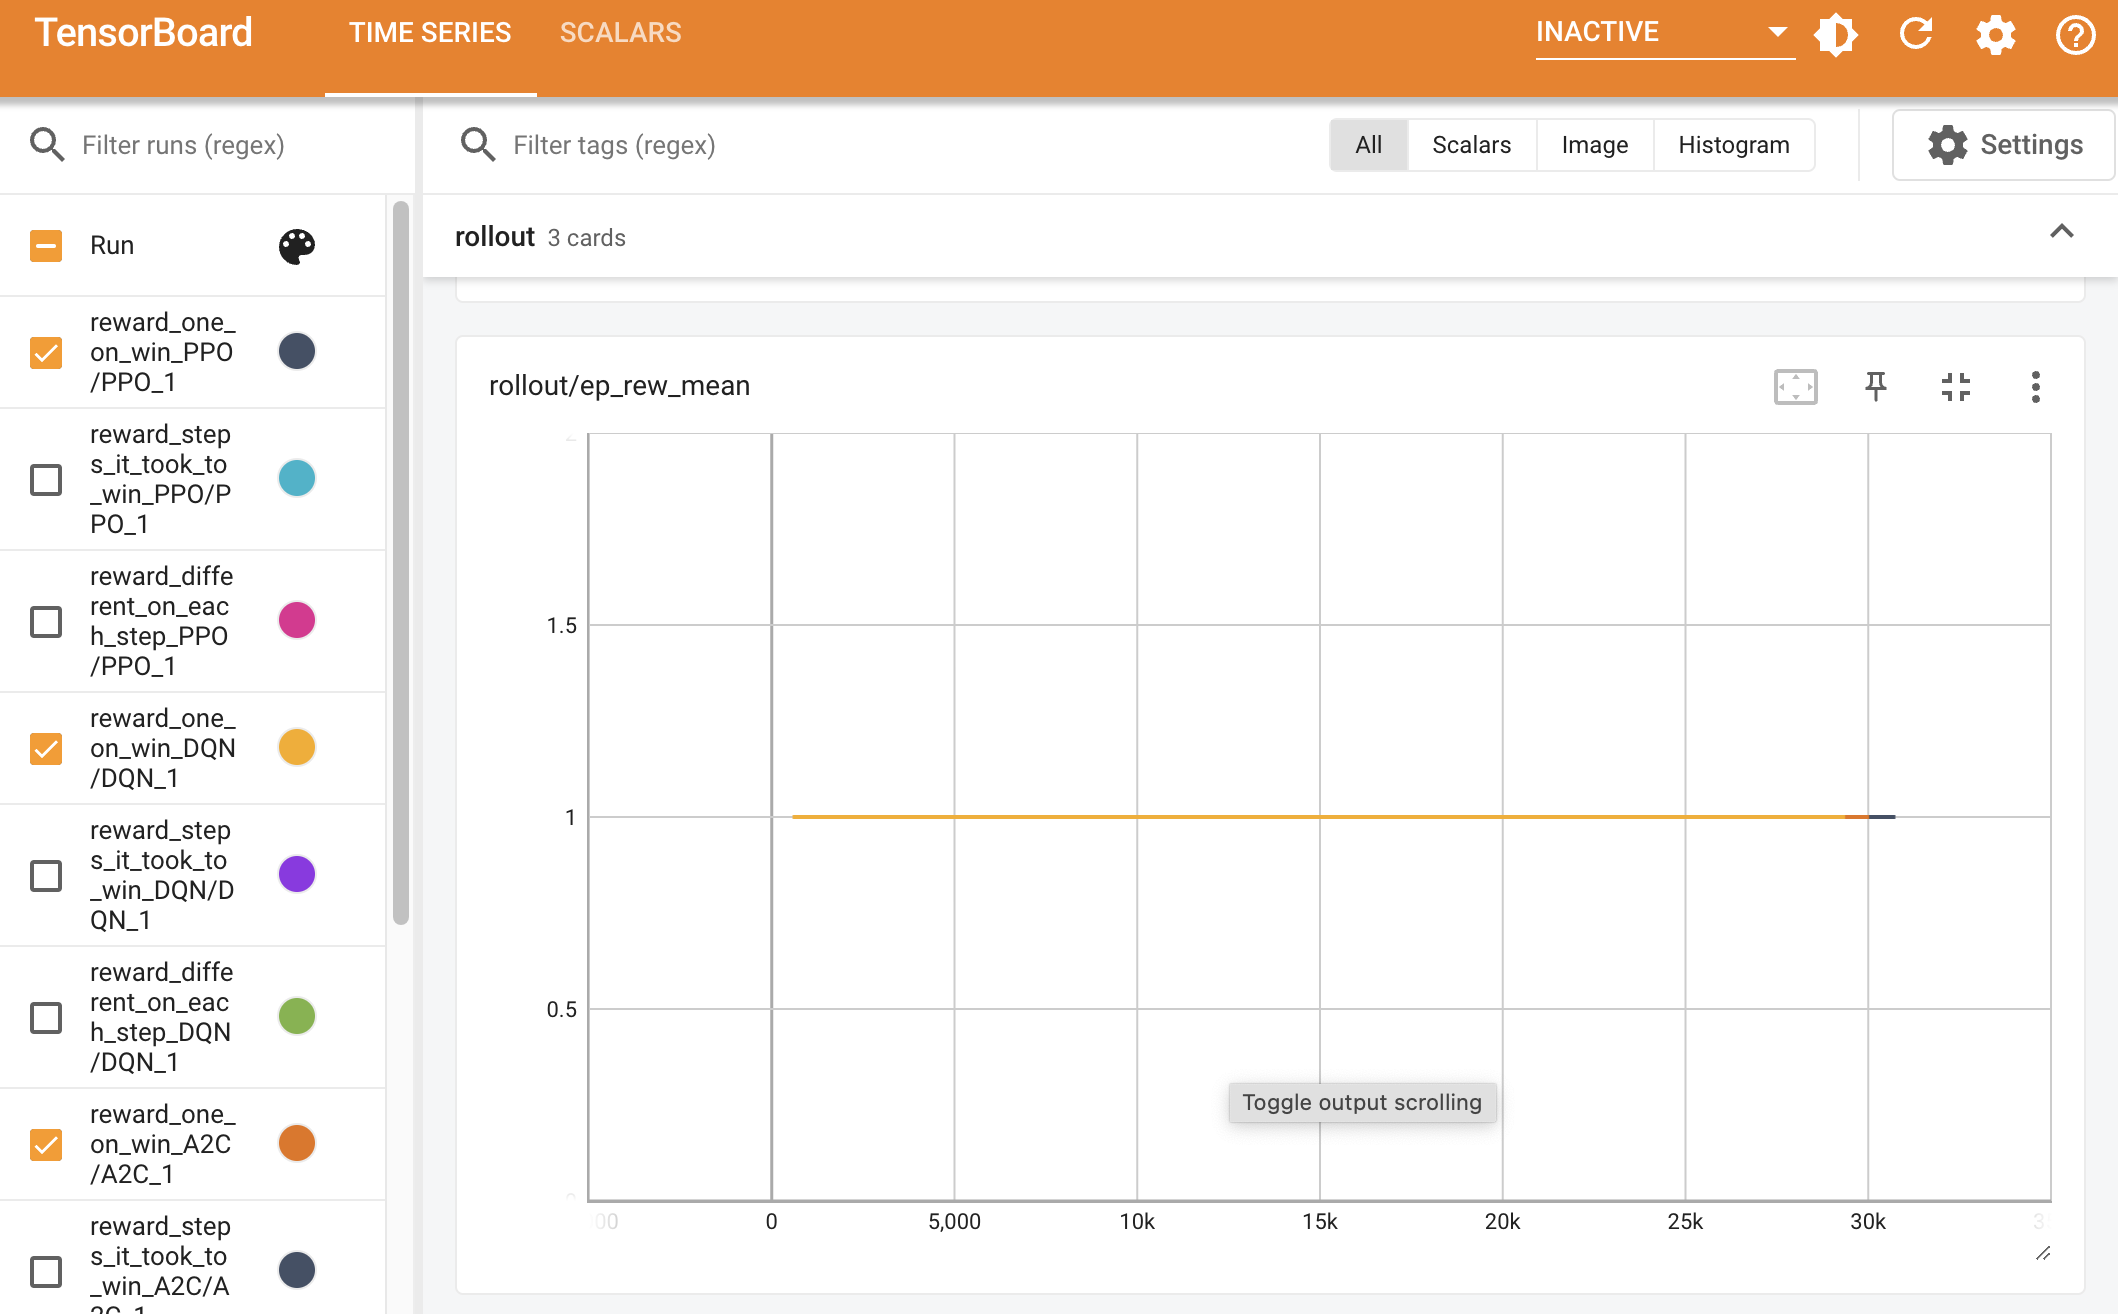

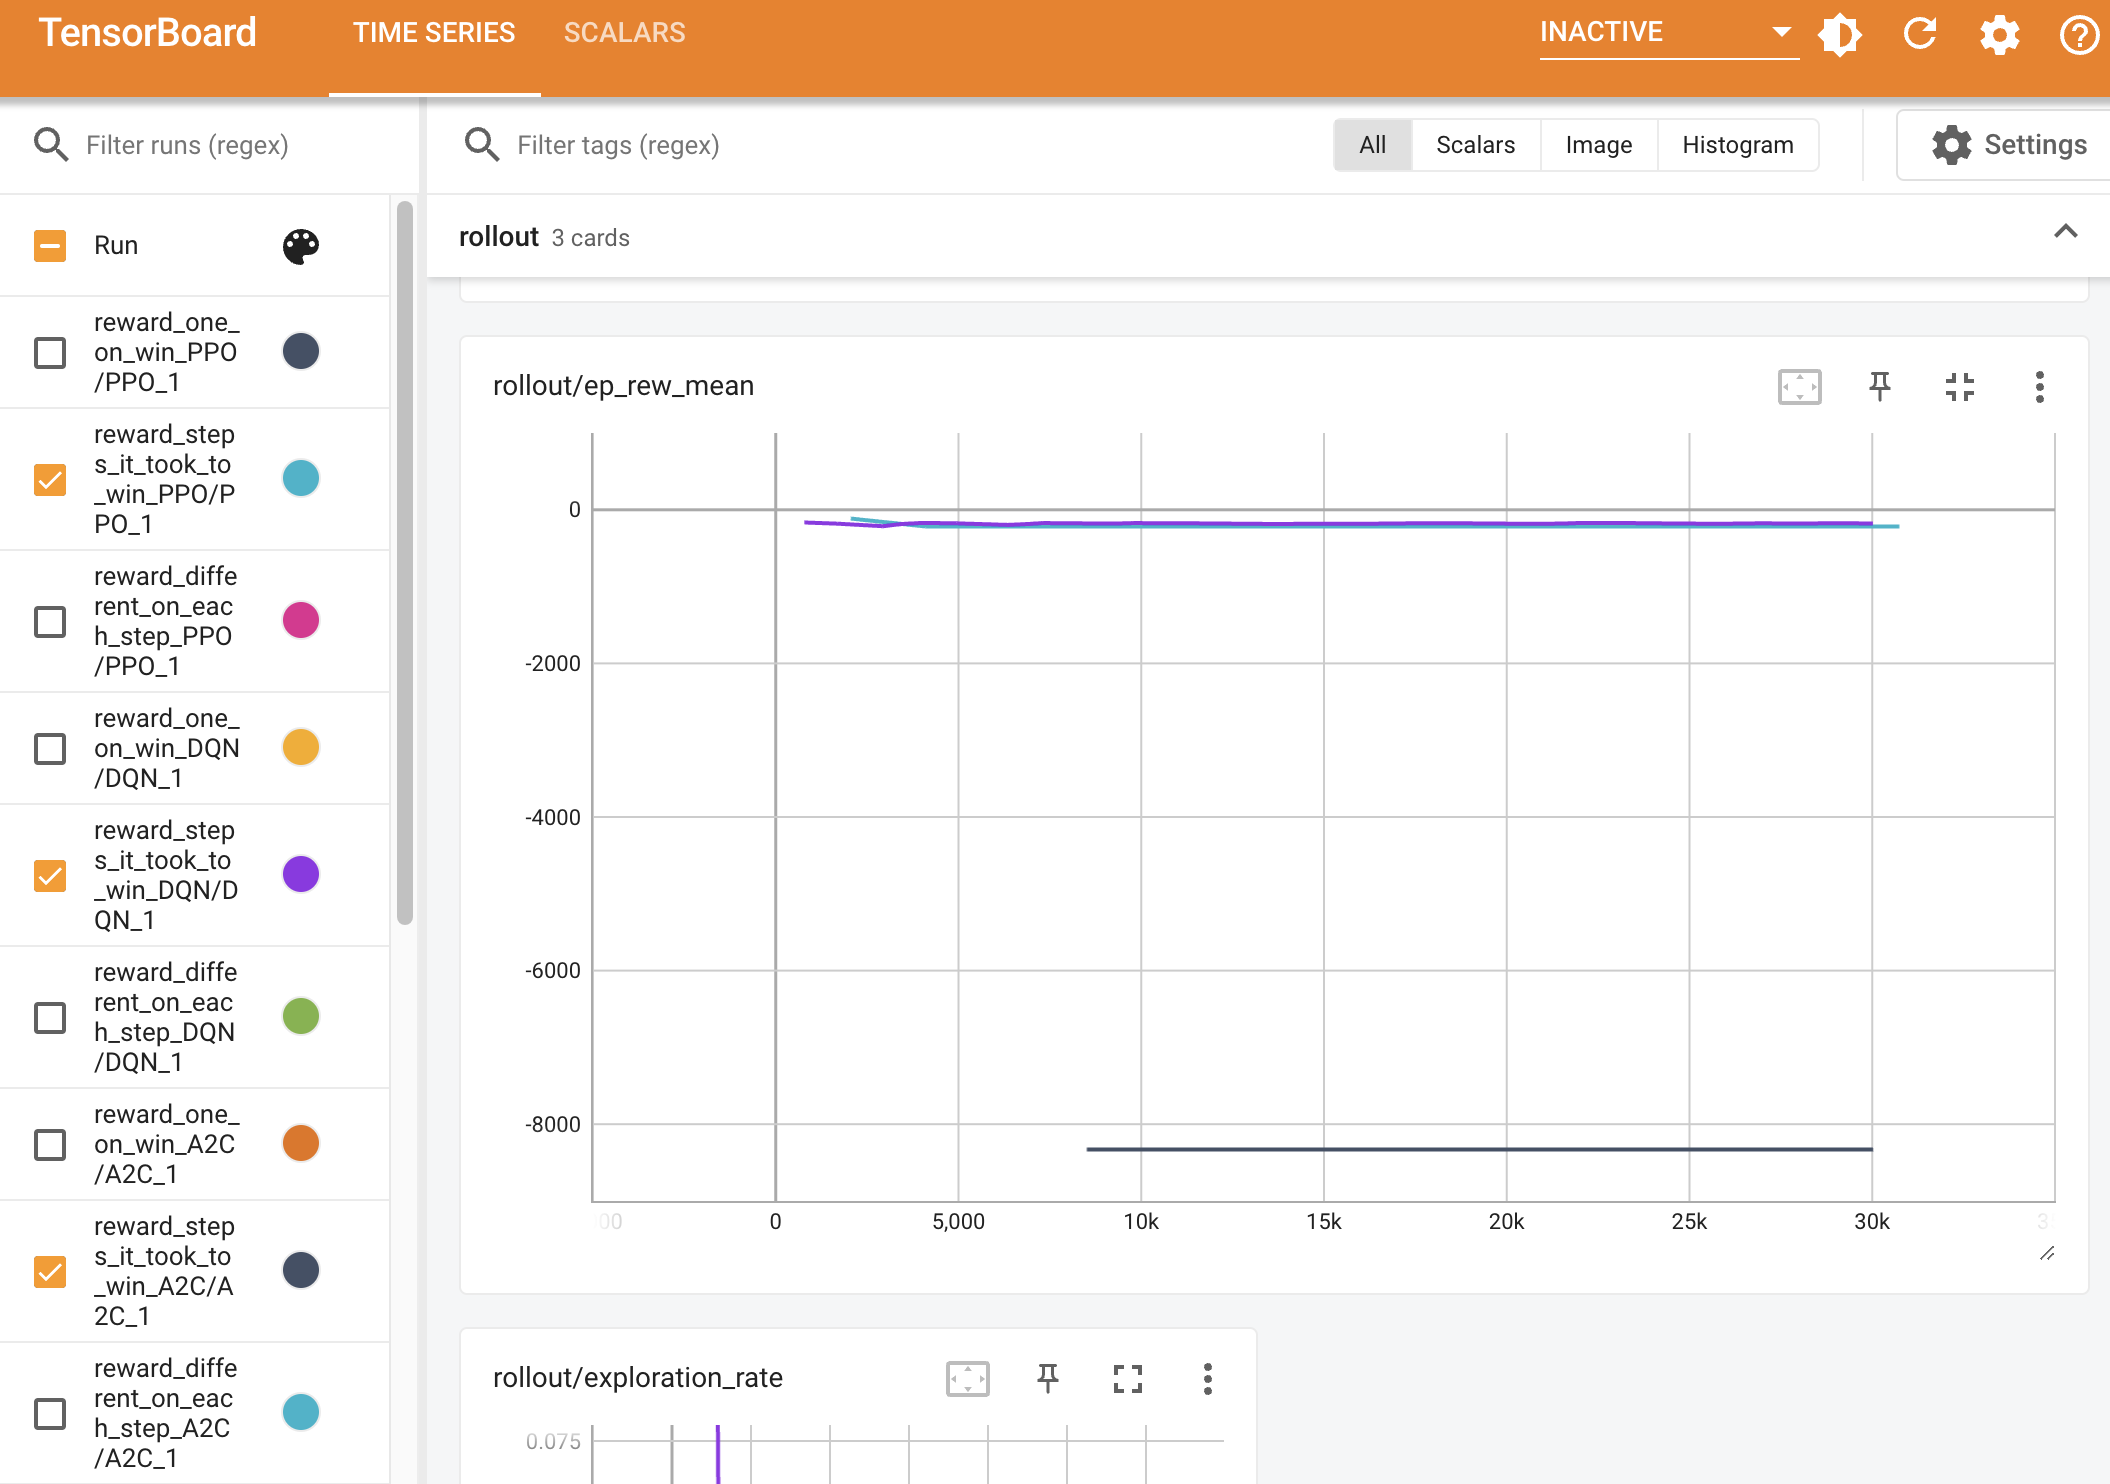

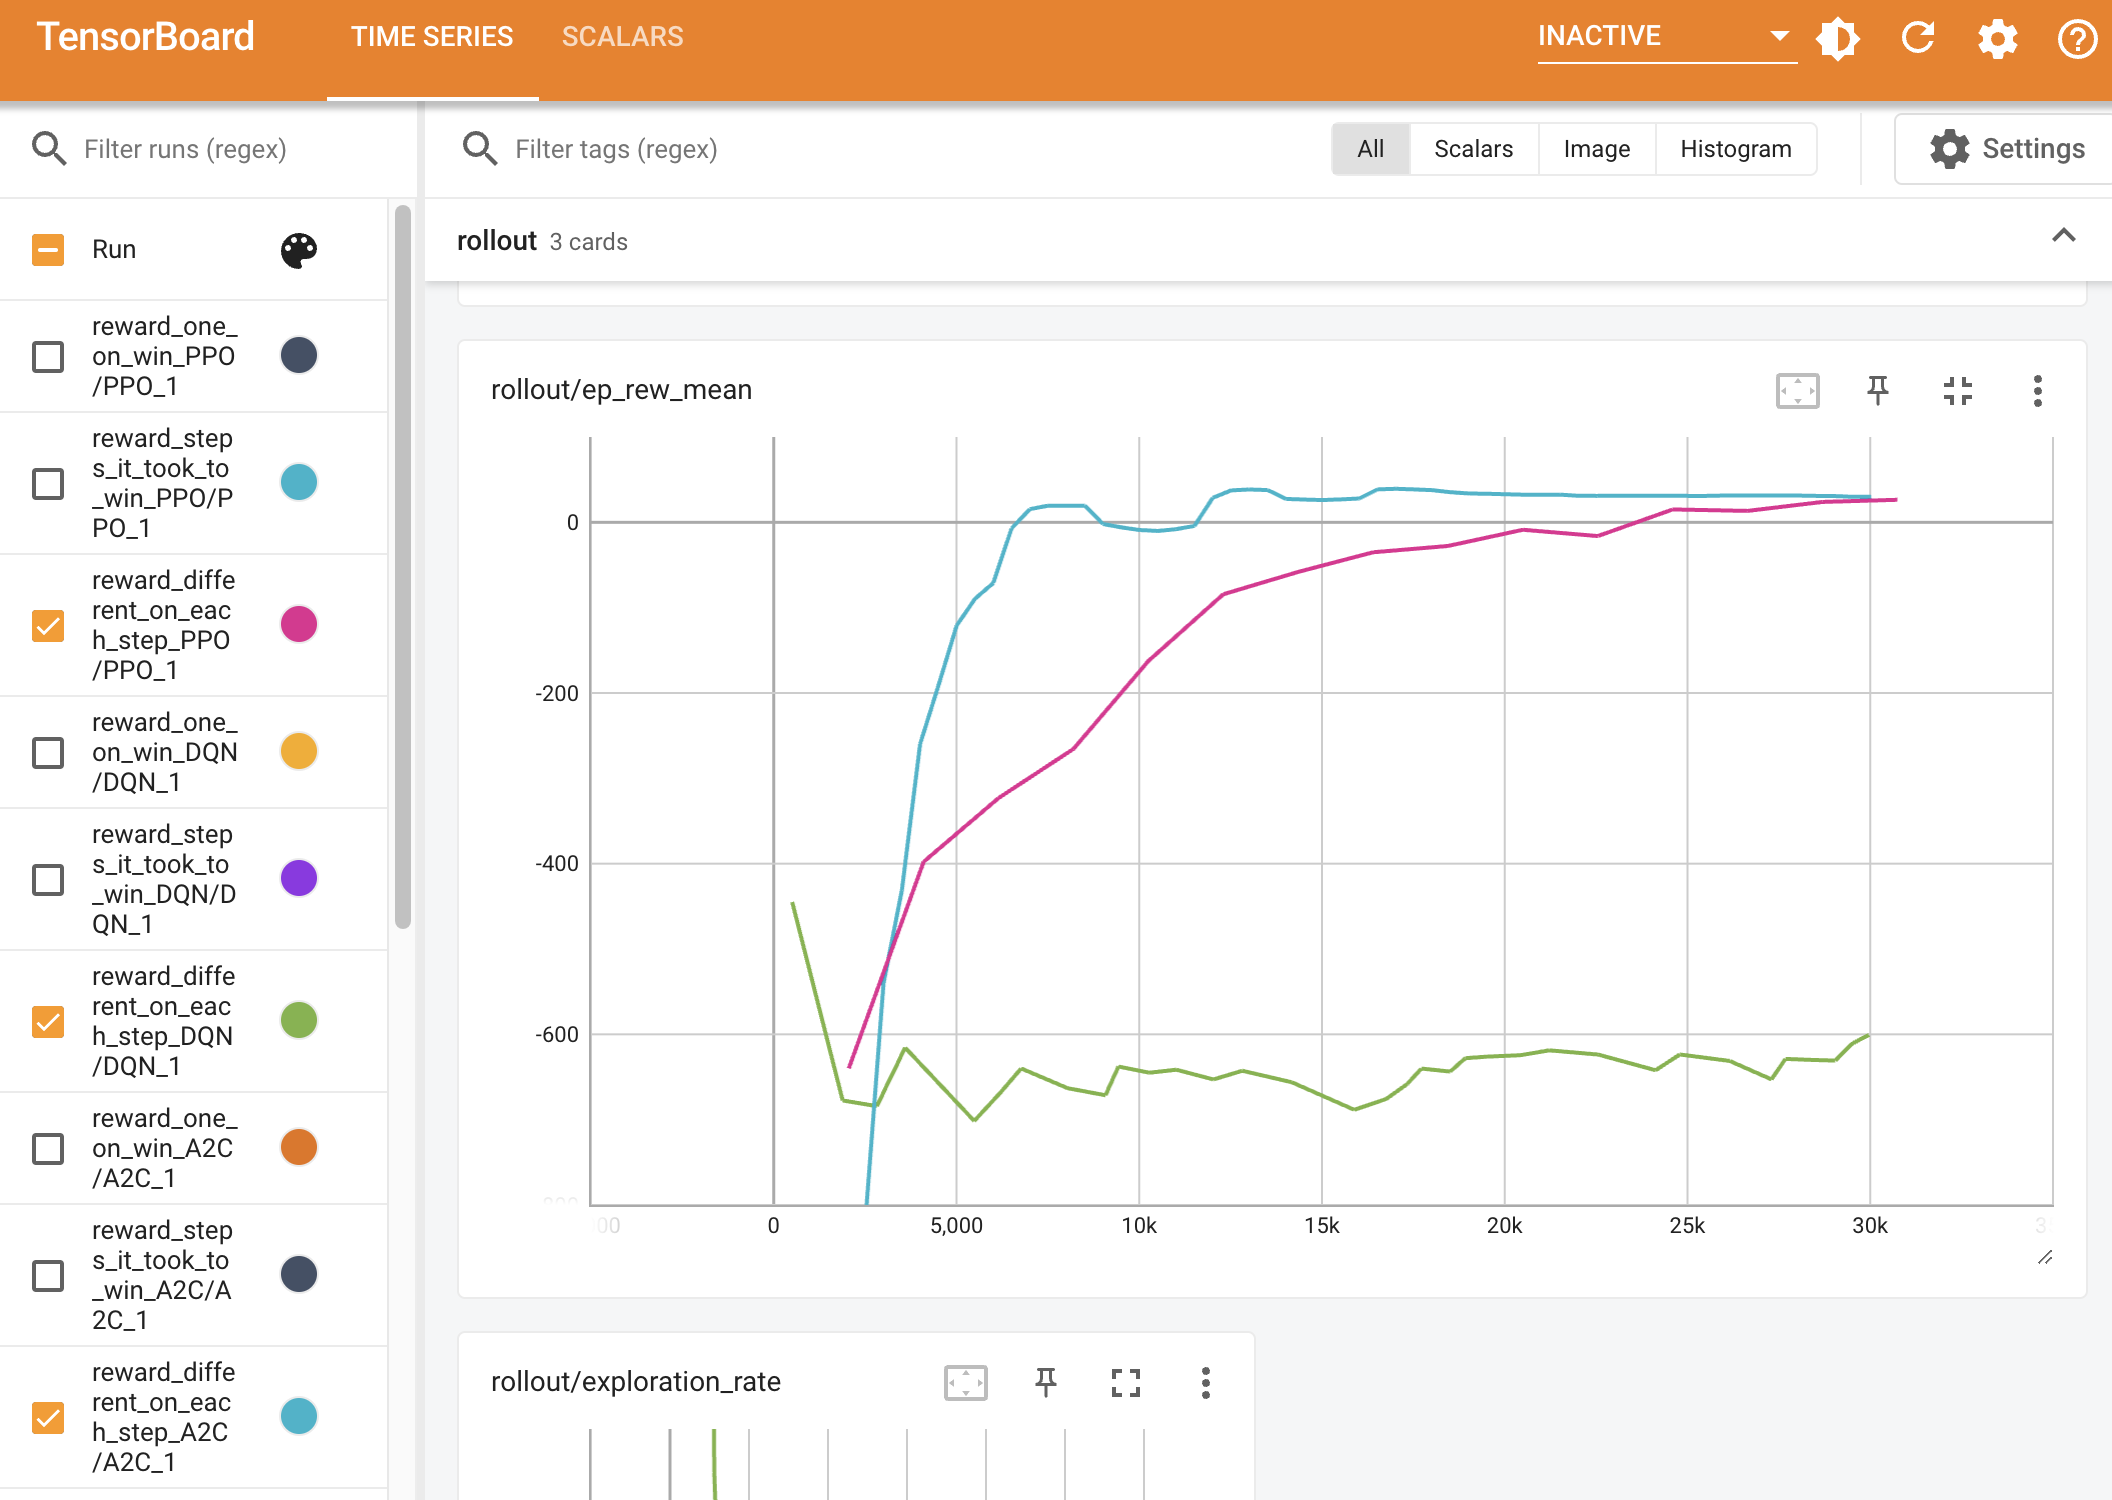

In [28]:
# Screenshots en caso de no tener tensorboard:

from IPython.display import display, Image
display(Image(filename="./reward_one_on_win.png"))
display(Image(filename="./reward_steps_it_took_to_win.png"))
display(Image(filename="./rewards_different_on_each_step.png"))

## Conclusiones

Con respecto a las funciones de recompensa implementadas, la que mejor desempeño tuvo fue aquella que devuelve distintos valores de recompensa en cada paso y no las que recompensan una vez que se ganó el juego.

PPO fue el algoritmo con mejor resultado; este demuestra convergencia al analizar los gráficos de reward por episodio. Al ver las soluciones del modelo entrenado, se evidencia que el agente actúa hacia el objetivo.

La mejor combinación resultó ser PPO junto con la función de recompensa de cada step (*reward_different_on_each_step*).

# Punto 2: entorno complejo

En este caso, para experimentar con la librería de Stable Baselines Zoo se entrenará el juego de Atari Breakout que ya viene implementado.
Luego del entrenamiento se verá cómo juega el agente.

In [29]:
# Entrenamiento del entorno BreakoutNoFrameskip-v4 usando RL Zoo

args = ["--algo", "ppo", "--env", "BreakoutNoFrameskip-v4", "-n", "30000"]
p = Popen(["python", "-m", "rl_zoo3.train"] + args, stdout=PIPE)
output, err = p.communicate()
rc = p.returncode
os.chdir(cwd)

assert rc == 0

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [30]:
# Ejecutar el agente entrenado

args = ["--algo", "ppo", "--env", "BreakoutNoFrameskip-v4", "-f", "logs/"]
p = Popen(["python", "-m", "rl_zoo3.enjoy"] + args, stdin=PIPE, stdout=PIPE, stderr=PIPE)
output, err = p.communicate()
rc = p.returncode
os.chdir(cwd)
assert rc == 0